In [1]:
using LinearAlgebra
using Distributions 
using Random
using Plots

1. Generate some data $(\mathbf{X}, \vec{y})$ to fit our Gaussian process to. 

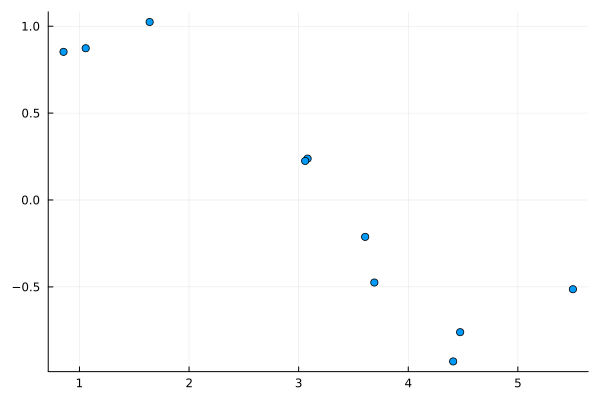

In [41]:
# function to sample from: 
hyperparams = (0.3, 1.08, 0.00005)
# hyperparams = (1.0, 1.0, 0.1)
# hyperparams = (3.0, 1.16, 0.89)


σₙ² = (hyperparams[3])^2
σf² = (hyperparams[2])^2
ℓ = hyperparams[1]

#σₙ² = (0.00005)^2
#σf² = (1.08)^2
#ℓ= 0.3

y(x) = sin(x) + 0.25*rand()

#X = 0:0.5:2π
X = 2π*rand(10)
yvec = y.(X)
X = X'


plot(X', yvec, seriestype=:scatter, label="")

2. Compute Kernel matrix on sample data. We will use RBF kernel given by 
\begin{equation}
k(\vec{x},\vec{x}') = \sigma_f^2 \exp\left(-\frac{1}{2\ell^2}(\vec{x}-\vec{x}')^2\right) + \sigma_n^2 \delta_{\vec{x},\vec{x}'}
\end{equation}

In [42]:
# first define how copute elemnt i,j 
function rbf_ij(X₁::AbstractMatrix, X₂::AbstractMatrix, i::Int, j::Int)
    return σf²*exp(-(X₁[:,i] .- X₂[:,j])' * (X₁[:,i] .- X₂[:,j])/(2ℓ^2))
end

rbf_ij(X,X, 1, 2)

1.2072410619235907e-36

In [43]:
function RBF(X₁::AbstractMatrix, X₂::AbstractMatrix)
    (d₁,n₁) = size(X₁)
    (d₂,n₂) = size(X₂)
    # we need to require d₁ == d₂
    K = zeros(n₁, n₂)
 
    @inline for j ∈ 1:n₂, i ∈ 1:n₁
        K[i,j] = rbf_ij(X₁, X₂, i, j)
    end
    
    return K 
end

K = RBF(X,X) + σₙ²*I

10×10 Matrix{Float64}:
 1.1664       1.20724e-36  2.45189e-48  …  0.00326319   2.50598e-9
 1.20724e-36  1.1664       0.176111        5.00161e-20  5.4461e-10
 2.45189e-48  0.176111     1.1664          7.99032e-29  2.39485e-16
 8.90248e-53  0.0377813    0.929027        2.93207e-32  6.17007e-19
 0.00153987   3.63603e-19  8.77975e-28     1.14038      0.0324489
 8.50476e-15  1.13391e-5   1.50052e-10  …  2.46776e-5   0.251933
 1.4025e-8    8.42776e-11  2.15536e-17     0.0386639    1.12196
 4.67446e-15  1.61236e-5   2.46309e-10     1.74716e-5   0.22078
 0.00326319   5.00161e-20  7.99032e-29     1.1664       0.0179663
 2.50598e-9   5.4461e-10   2.39485e-16     0.0179663    1.1664

In [44]:
# visualize the covariance matrix
# heatmap(log10.(K), yflip=true)
heatmap(log10.(K), yflip=true, title)

LoadError: UndefVarError: title not defined

In [45]:
L = cholesky(K).L

10×10 LowerTriangular{Float64, Matrix{Float64}}:
 1.08          ⋅             ⋅           …    ⋅           ⋅         ⋅ 
 1.11782e-36  1.08           ⋅                ⋅           ⋅         ⋅ 
 2.27027e-48  0.163066      1.06762           ⋅           ⋅         ⋅ 
 8.24304e-53  0.0349827     0.864843          ⋅           ⋅         ⋅ 
 0.00142581   3.36669e-19  -5.14222e-20       ⋅           ⋅         ⋅ 
 7.87478e-15  1.04992e-5   -1.60348e-6   …    ⋅           ⋅         ⋅ 
 1.29862e-8   7.80348e-11  -1.19189e-11       ⋅           ⋅         ⋅ 
 4.3282e-15   1.49293e-5   -2.28004e-6       0.0772625    ⋅         ⋅ 
 0.00302147   4.63112e-20  -7.07348e-21     -0.00586413  0.225511   ⋅ 
 2.32035e-9   5.04268e-10  -7.70207e-11     -0.140141    0.043703  0.233529

In [46]:
# compute expansion coefficients
α = (L')\(L\yvec)

size(α)

(10,)

In [47]:
# now we need a function to compue mean 
Xnew = (0:0.05:2π)'
Koldnew = RBF(X, Xnew)
ynew = Koldnew'*α

126-element Vector{Float64}:
  0.011873175332329991
  0.01890005895861529
  0.029275026692160967
  0.04412581281161417
  0.06472557190046956
  0.09240107743940938
  0.12838993168043683
  0.17365146860976152
  0.22864836701689936
  0.29312919996405884
  0.36595296075628786
  0.44500127417216745
  0.5272193314511612
  ⋮
 -0.41527299446123206
 -0.3670383209332232
 -0.31548213256313207
 -0.26372082713435513
 -0.21440390231560852
 -0.16953010032397228
 -0.13037404125378832
 -0.09751426248271047
 -0.0709380654448476
 -0.05019097082140306
 -0.03453881343590737
 -0.02311666012716409

In [48]:
# compute the variance
vvec = L\Koldnew

Knewnew = RBF(Xnew, Xnew)
varnew =Knewnew .- vvec'*vvec; 

twostdevs = [2*sqrt(varnew[i,i]) for i ∈ 1:size(Xnew,2)]

126-element Vector{Float64}:
 2.1592545853547938
 2.1581688885378147
 2.1557556804492393
 2.1507175572698447
 2.140842386561098
 2.122672697234614
 2.0912852992217474
 2.0403503665638447
 1.962632122015842
 1.8510108007326496
 1.6999608355567488
 1.5072570596808714
 1.2755518334534017
 ⋮
 1.2822521528445716
 1.5187573900207985
 1.7097856150446578
 1.856987495435703
 1.9649861253594365
 2.040267977163634
 2.090020959461591
 2.1211362947515373
 2.1395214201422843
 2.1497728464784647
 2.1551630269520623
 2.1578345950990916

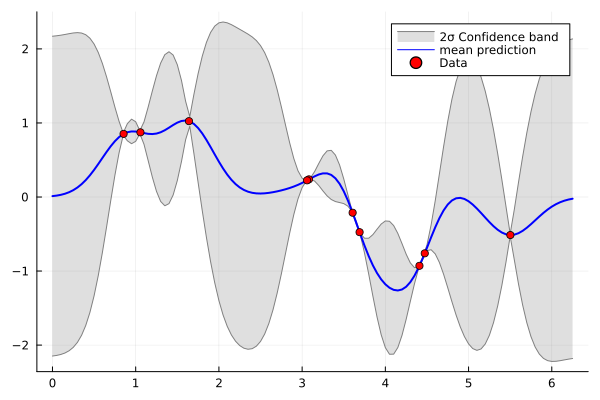

In [49]:
plot(Xnew', ynew .+ twostdevs, c=:gray, label="")
plot!(Xnew', ynew .- twostdevs, fillrange = ynew .+ twostdevs, fillalpha = 0.25, c = :gray, label = "2σ Confidence band")
plot!(Xnew', ynew, c=:blue, lw=2, label="mean prediction")
plot!(X', yvec, seriestype=:scatter, color=:red, label="Data")

In [50]:
savefig("gpr_demo.pdf")

In [51]:
savefig("gpr_demo.png")